This is the paper: https://arxiv.org/abs/2208.12242

## 0 preparation

In [206]:
# !wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
# !wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
# %pip install -qq git+https://github.com/ShivamShrirao/diffusers
# %pip install -q -U --pre triton
# %pip install -q accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors xformers

In [ ]:
# !mkdir -p ~/.huggingface
# !echo -n "yourtoken" > ~/.huggingface/token

In [205]:
MODEL_NAME = "runwayml/stable-diffusion-v1-5" 

#  the directory name to save model at
OUTPUT_DIR = "./weights_saved"
print(f"[*] Weights will be saved at {OUTPUT_DIR}")

[*] Weights will be saved at ./weights_saved


## 1 train

In [10]:
# You can also add multiple concepts here. Try tweaking `--max_train_steps` accordingly.

concepts_list = [
    {
        "instance_prompt":      "argentinanana banknote design",
        "class_prompt":         "banknote design",
        "instance_data_dir":    "./data/argentinanana_banknote",
        "class_data_dir":       "./data/argentinanana_banknote_class"
    },
]

# `class_data_dir` contains regularization images
import json
import os
for c in concepts_list:
    os.makedirs(c["instance_data_dir"], exist_ok=True)

with open("concepts_list.json", "w") as f:
    json.dump(concepts_list, f, indent=4)

In [ ]:
# ''' if you meet bug below says: NameError: name 'str2optimizer8bit_blockwise' is not defined, please install the latest bitsandbytes version'''
# !python -m bitsandbytes
# !pip install -U bitsandbytes

In [13]:
!python3 train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir=$OUTPUT_DIR \
  --revision="fp16" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=2400 \
  --save_interval=10000 \
  --save_sample_prompt="argentinanana banknote design" \
  --concepts_list="concepts_list.json"

# Reduce the `--save_interval` to lower than `--max_train_steps` to save weights from intermediate steps.
# `--save_sample_prompt` can be same as `--instance_prompt` to generate intermediate samples (saved along with weights in samples directory).

2024-02-17 07:19:11.347050: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 07:19:11.347117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 07:19:11.348245: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-17 07:19:11.355215: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
config.json: 100%|█████████████████████████████| 547/

In [15]:
WEIGHTS_DIR = "" 
if WEIGHTS_DIR == "":
    from natsort import natsorted
    from glob import glob
    import os
    WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR + os.sep + "*"))[-1]
print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")

[*] WEIGHTS_DIR=./weights_saved/2400


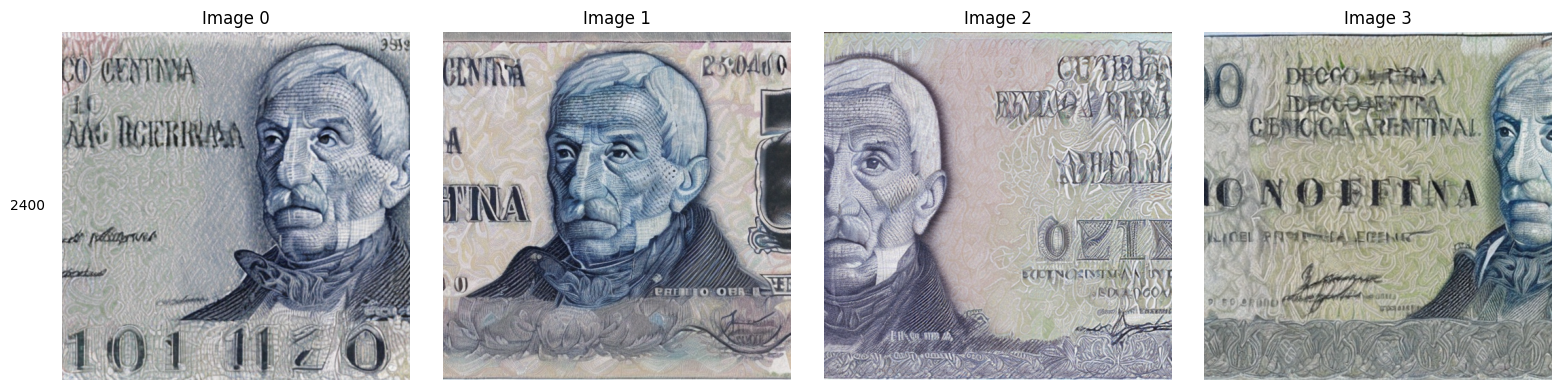

In [16]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

weights_folder = OUTPUT_DIR
folders = sorted([f for f in os.listdir(weights_folder) if f != "0"], key=lambda x: int(x))

row = len(folders)
col = len(os.listdir(os.path.join(weights_folder, folders[0], "samples")))
scale = 4
fig, axes = plt.subplots(row, col, figsize=(col*scale, row*scale), gridspec_kw={'hspace': 0, 'wspace': 0})

for i, folder in enumerate(folders):
    folder_path = os.path.join(weights_folder, folder)
    image_folder = os.path.join(folder_path, "samples")
    images = [f for f in os.listdir(image_folder)]
    for j, image in enumerate(images):
        if row == 1:
            currAxes = axes[j]
        else:
            currAxes = axes[i, j]
        if i == 0:
            currAxes.set_title(f"Image {j}")
        if j == 0:
            currAxes.text(-0.1, 0.5, folder, rotation=0, va='center', ha='center', transform=currAxes.transAxes)
        image_path = os.path.join(image_folder, image)
        img = mpimg.imread(image_path)
        currAxes.imshow(img, cmap='gray')
        currAxes.axis('off')

plt.tight_layout()
plt.savefig('grid.png', dpi=72)

## 2 inference

In [17]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

model_path = WEIGHTS_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive

pipe = StableDiffusionPipeline.from_pretrained(model_path, safety_checker=None, torch_dtype=torch.float16).to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
g_cuda = None

2024-02-17 08:03:27.058035: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 08:03:27.058106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 08:03:27.059445: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-17 08:03:27.066822: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/transformers/

In [68]:
# Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')
seed = 723875
g_cuda.manual_seed(seed)

  0%|          | 0/24 [00:00<?, ?it/s]

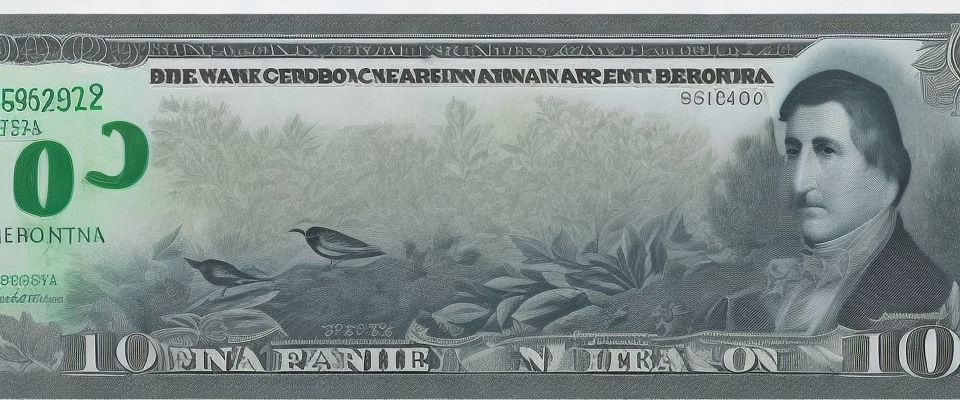

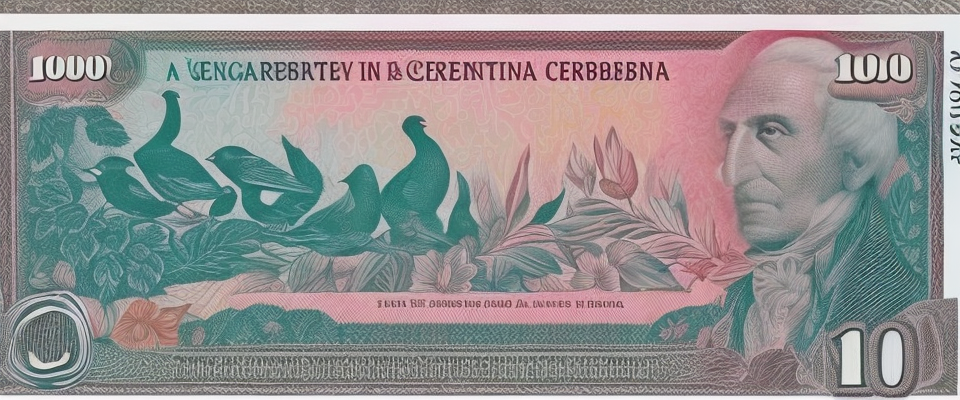

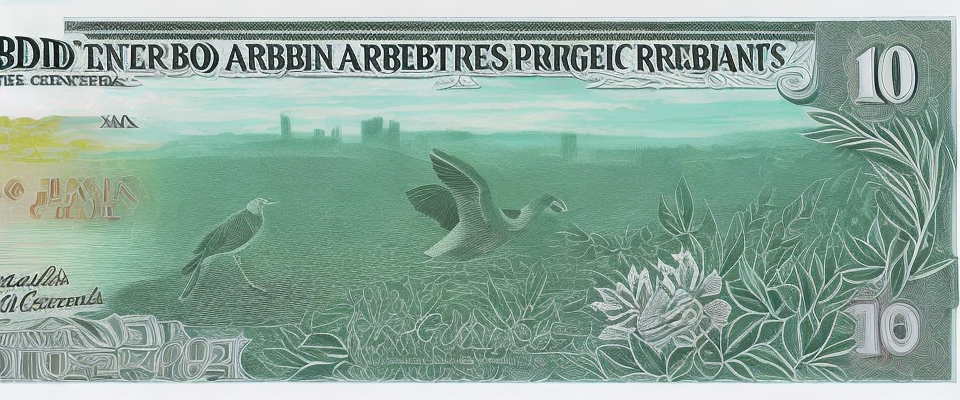

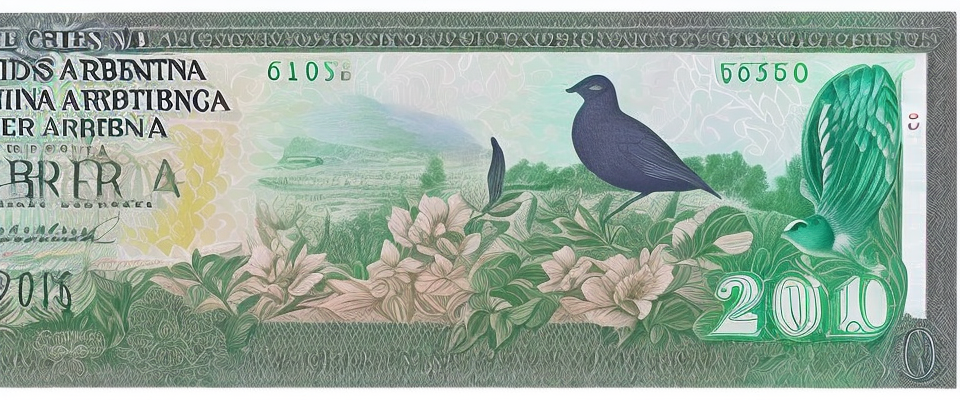

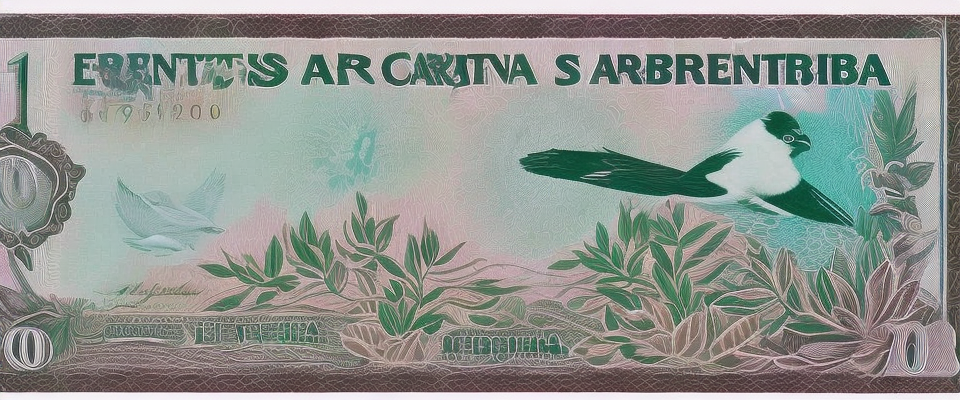

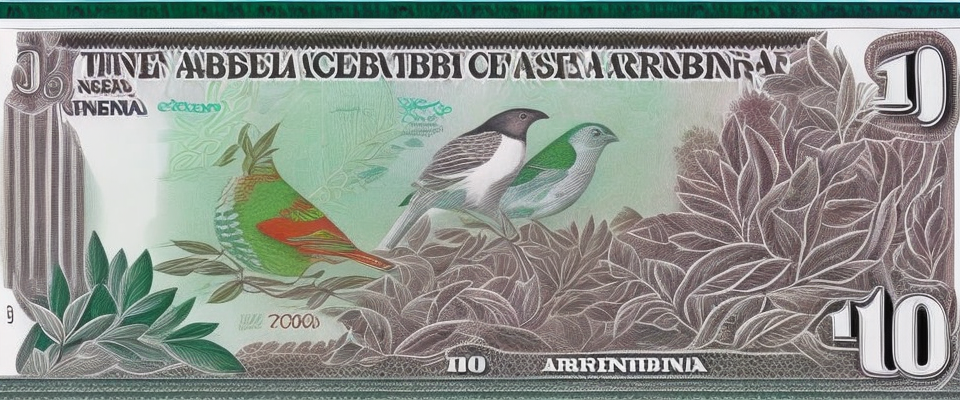

In [202]:
#@title Run for generating images.

prompt = "bird bird bird bird bird bird bird bird bird print argentinana banknote design" #bird+++++ may help too #@param {type:"string"} #modern old woman
negative_prompt = "deformed, disfigured, poor details, bad anatomy" #@param {type:"string"}
num_samples = 6 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 24 #set higher for finer results a#@param {type:"number"}
height = 400 #@param {type:"number"}
width = 960 #@param {type:"number"}

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)

In [207]:
images[1].save("./results_to_be_shared/52.png")

## 3 display and save (alternative ways)

### 3.1 display and save ALL images

In [ ]:
from datetime import datetime

for index, image in enumerate(images):
    display(image)
    
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S%f")
    filename = f"./results/{timestamp}_{index}.png"

    image.save(filename)

### 3.2 or display and save image selectively

In [ ]:
for img in images:
    display(img)

filename = "filename_for_this_specific_image"
image_number = 0 #@param {type:"number"} start from 0
images[image_number].save(f"./results/{filename}.png")